In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("../DataSets/Egypt_Houses_Price.csv")

# Replace specific values in the 'Level' column
df['Level'] = df['Level'].replace({'Unknown': 0, 'Ground': 0, '10+': 10, 'Highest': 11})

# Filter out rows that do not match the specified types
types_to_keep = ['Apartment', 'Duplex', 'Stand Alone Villa', 'Chalet']
df = df[df['Type'].isin(types_to_keep)]

# Convert 'Type' to dummy variables
df = df.join(pd.get_dummies(df['Type'])).drop(['Type'], axis=1)
df.dropna(inplace=True)
df.isna().sum()

Price                0
Bedrooms             0
Bathrooms            0
Area                 0
Furnished            0
Level                0
Compound             0
Payment_Option       0
Delivery_Date        0
Delivery_Term        0
City                 0
Apartment            0
Chalet               0
Duplex               0
Stand Alone Villa    0
dtype: int64

In [3]:
X = df[["Area","Bedrooms","Bathrooms","Level","Apartment","Chalet","Duplex","Stand Alone Villa"]]
y = df["Price"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

train_data = X_train.join(y_train)

In [5]:
train_data = train_data.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values
train_data.dropna(inplace=True)

# Add 'Total Rooms' feature to X_train
X_train['Total Rooms'] = X_train['Bedrooms'] + X_train['Bathrooms']


<Axes: >

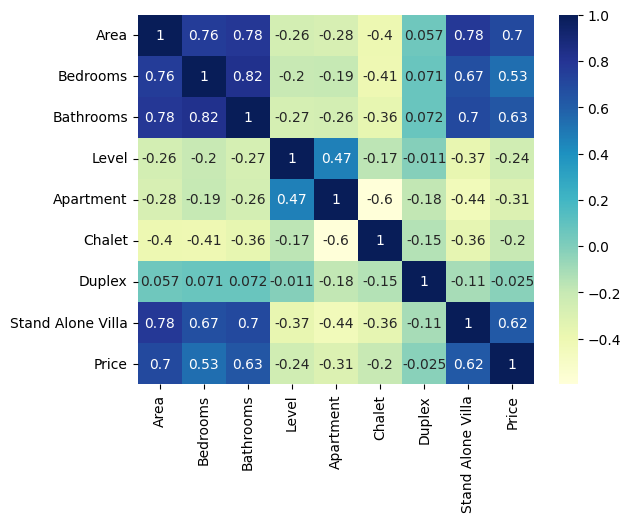

In [6]:
sns.heatmap(train_data.corr(),annot=True,cmap="YlGnBu")

In [7]:

# We dont need to scale o/o == y
# scaler = StandardScaler()
# X_train_s = scaler.fit_transform(X_train)

# Recreate X_train and y_train from the cleaned train_data
X_train = train_data.drop(columns=["Price"])
y_train = train_data["Price"]

# scaler = StandardScaler()
# X_train_s = scaler.fit_transform(X_train)

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [8]:
test_data = X_test.join(y_test)
X_test = test_data.drop(['Price'],axis=1)
y_test = test_data['Price']

# X_test_s = scaler.transform(X_test)

In [9]:
lm.score(X_test, y_test)

0.4509214046341701

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [14]:
# To improve or enhance our res
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lm.fit(X_train_poly, y_train)
print(lm.score(X_test_poly, y_test))

0.4623574905386808
